In [1]:
from abc import ABCMeta, abstractmethod

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from datetime import datetime

%matplotlib inline

# Байесовские бандиты <font color="green" size=6> (вплоть до 14 баллов) </font>
<font color="green" size=6> 10 баллов &mdash; основное задание, 4 балла &mdash; бонусное задание </font>
#### дедлайн (сразу жёсткий) задания: 14.05.2025, 23:59 GMT+3
<font color="red" size=6> Если работа была списана и/или сделана LLM, то за работу ставится 0 баллов </font>

# Работа выполнена: Лотфуллин Камиль Рашитович, М05-401

# Бандиты  <font color="green" size=6> (3 балла) &mdash; основное задание</font>

1. <font color="green"> [0.6 балла] </font> $\varepsilon$-жадный алгоритм
2. <font color="green"> [0.9 балла] </font> UCB
3. <font color="green"> [0.6 балла] </font> сэмплирование по Томпсону
4. <font color="green"> [0.9 балла] </font> собственная стратегия

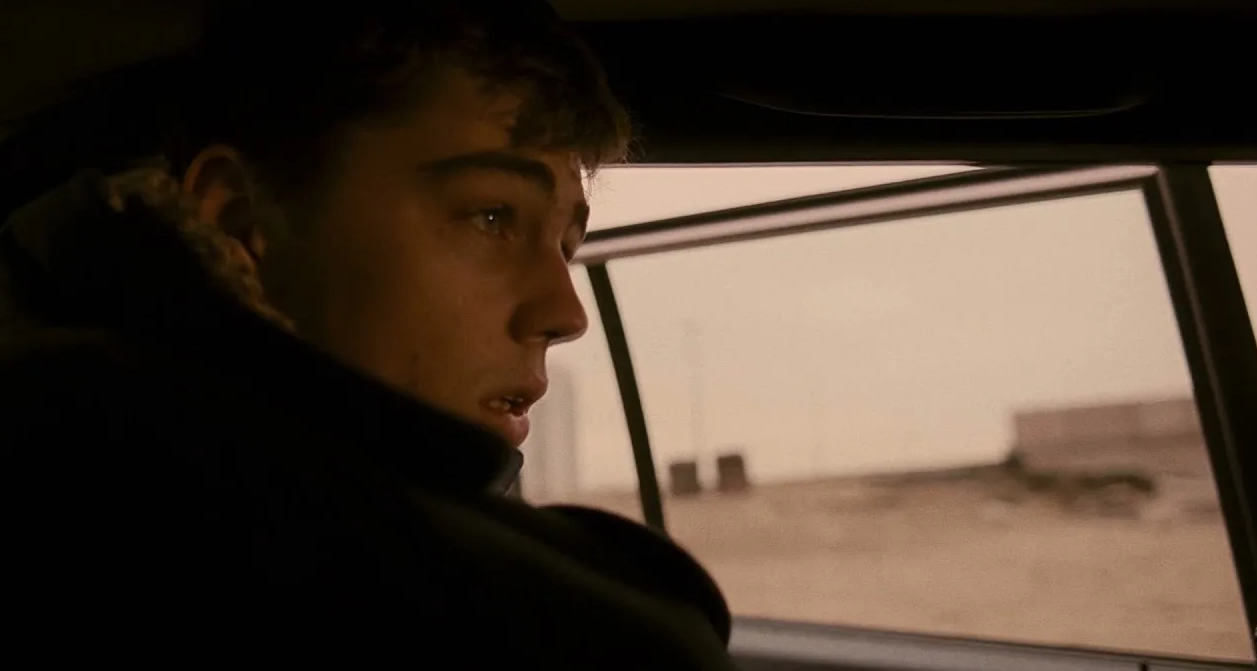


В данной работе исследуется простая задача о многоруких бандитах с распределениями Бернулли и несколько стратегий её решения.

Бандиты имеют $K$ действий. Действие ведёт к награде $r=1$ с вероятностью $0 \le \theta_k \le 1$, неизвестной для агента, но фиксированной во времени. Цель агента состит в минимизации общей субоптимальности выполненных $T$ действий:

$$\rho = T\theta^* - \sum_{t=1}^T r_t,$$

и $\theta^* = \max_k\{\theta_k\}$.

**Пример из жизни** &mdash; клинические испытания: у нас есть $k$ видов лекарств и $T$ пациентов. После принятия лекарства пациент излечивается с вероятностью $\theta_k$. Цель состоит в поиске оптимального лекарства. Обзор по клиническим испытаниям &mdash; https://arxiv.org/pdf/1507.08025.pdf.


Для того, чтобы получить максимальный балл, имплементируйте следующих агентов (будут указаны ниже):



In [2]:
SEED = 617  # Значение данной переменной не должно изменяться!


class BernoulliBandit:
    def __init__(self, n_actions=5):
        self._probs = np.random.random(n_actions)

    @property
    def action_count(self):
        return len(self._probs)

    def pull(self, action):
        if np.any(np.random.random() > self._probs[action]):
            return 0.
        return 1.

    def optimal_reward(self):
        """Используется для вычисления регрета"""
        return np.max(self._probs)

    def step(self):
        """Используется в нестационарной версии"""
        pass

    def reset(self):
        """Используется в нестационарной версии"""

In [3]:
class AbstractAgent(metaclass=ABCMeta):
    def init_actions(self, n_actions):
        self._successes = np.zeros(n_actions)
        self._failures = np.zeros(n_actions)
        self._total_pulls = 0

    @abstractmethod
    def get_action(self):
        """
        Получить текущее наилучшее действие
        :возвращаемый тип данных: int
        """
        pass

    def update(self, action, reward):
        """
        Учёт полученной награды в результате совершённого действия и обновление внутренних параметров агента
        :тип данных action: int
        :тип данных reward: int
        """
        self._total_pulls += 1
        if reward == 1:
            self._successes[action] += 1
        else:
            self._failures[action] += 1

    @property
    def name(self):
        return self.__class__.__name__


class RandomAgent(AbstractAgent):
    def get_action(self):
        return np.random.randint(0, len(self._successes))

### Эпсилон-жадный агент

> **for** $t = 1,2,...$ **do**

>> **for** $k = 1,...,K$ **do**

>>> $\hat\theta_k \leftarrow \alpha_k / (\alpha_k + \beta_k)$

>> **end for**

>> $x_t \leftarrow argmax_{k}\hat\theta$ с вероятностью $1 - \varepsilon$ или равномерно случайное действие с вероятностью $\varepsilon$

>> Применить $x_t$ и получить $r_t$

>> $(\alpha_{x_t}, \beta_{x_t}) \leftarrow (\alpha_{x_t}, \beta_{x_t}) + (r_t, 1-r_t)$

> **end for**

Реализуйте описанный выше алгоритм:

In [4]:
class EpsilonGreedyAgent(AbstractAgent):
    def __init__(self, epsilon=.01, base_interest=0.4):
        self._epsilon = epsilon
        self.base_interest = base_interest

    def get_action(self):
        if np.random.random() < self._epsilon:
            return np.random.randint(0, len(self._successes))
        else:
            estimates = np.zeros(len(self._successes))
            totals = self._successes + self._failures

            valid_indices = np.where(totals > 0)[0]
            if len(valid_indices) > 0:
                 estimates[valid_indices] = self._successes[valid_indices] / totals[valid_indices]


            unpulled_indices = np.where(totals == 0)[0]
            estimates[unpulled_indices] = self.base_interest

            max_estimate = np.max(estimates)
            best_actions = np.where(estimates == max_estimate)[0]
            return np.random.choice(best_actions)

    @property
    def name(self):
        return self.__class__.__name__ + "(epsilon={})".format(self._epsilon)

### UCB агент
Эпсилон-жадная стратегия не имеет предпочтений на этапе случайного выбора. Возможно, лучше выбирать действия, в которых нет достаточной уверенности, но которые имеют потенциал в будущем стать оптимальными. На основе данной интуиции можно ввести меру одновременно оптмальности и неопределённости.

Одно из возможных решений для этого вополщено в UCB1 алгоритме:

> **for** $t = 1,2,...$ **do**
>> **for** $k = 1,...,K$ **do**
>>> $w_k \leftarrow \alpha_k / (\alpha_k + \beta_k) + \sqrt{2log\ t \ / \ (\alpha_k + \beta_k)}$

>> **end for**

>> $x_t \leftarrow argmax_{k}w$

>> Применить $x_t$ и получить $r_t$

>> $(\alpha_{x_t}, \beta_{x_t}) \leftarrow (\alpha_{x_t}, \beta_{x_t}) + (r_t, 1-r_t)$

> **end for**

Другие решения и анализ оптимальности &mdash; https://homes.di.unimi.it/~cesabian/Pubblicazioni/ml-02.pdf.

In [5]:
class UCBAgent(AbstractAgent):
    def get_action(self):
        n_pulls_arm = self._successes + self._failures

        unpulled_arms = np.where(n_pulls_arm == 0)[0]
        if len(unpulled_arms) > 0:
            return np.random.choice(unpulled_arms)

        if self._total_pulls == 0:
             return np.random.randint(0, len(self._successes))

        ucb_values = np.zeros(len(self._successes))
        for k in range(len(self._successes)):
            mean_reward_k = self._successes[k] / n_pulls_arm[k]
            exploration_bonus = np.sqrt((2 * np.log(self._total_pulls)) / n_pulls_arm[k])
            ucb_values[k] = mean_reward_k + exploration_bonus

        max_ucb = np.max(ucb_values)
        best_actions = np.where(ucb_values == max_ucb)[0]
        return np.random.choice(best_actions)

### Сэмплирование по Томпсону

UCB1 не рассматривает распределение наград. Если оно известно, то можно улучшить UCB1 алгоритм добавлением сэмплирования по Томпсону.

Предполагается, что $\theta_k$ независимые и одинаково распределены. В качестве априорного распределения будем использовать бета-распределение с параметрами $\alpha=(\alpha_1, \dots, \alpha_k)$ и $\beta=(\beta_1, \dots, \beta_k)$. Следовательно, для каждого параметра $\theta_k$ функция плотности априорного распределения выглядит как
$$
p(\theta_k) =
\frac{\Gamma(\alpha_k + \beta_k)}{\Gamma(\alpha_k) + \Gamma(\beta_k)}
\theta_k^{\alpha_k - 1}(1 - \theta_k)^{\beta_k - 1}
$$
После получения нового наблюдения распределение обновляется согласно правилу Байеса.

C бета-распределением удобно работать из-за сопряжения &mdash; апостериорное распределение будет так же бета-распределением, поэтому параметры можно легко обновлять:

> **for** $t = 1,2,...$ **do**
>> **for** $k = 1,...,K$ **do**
>>> Сэмплировать $\hat\theta_k \sim beta(\alpha_k, \beta_k)$

>> **end for**

>> $x_t \leftarrow argmax_{k}\hat\theta$

>> Применить $x_t$ и получить $r_t$

>> $(\alpha_{x_t}, \beta_{x_t}) \leftarrow (\alpha_{x_t}, \beta_{x_t}) + (r_t, 1-r_t)$

> **end for**

Теория и практика сэмплирования по Томпсону: https://web.stanford.edu/~bvr/pubs/TS_Tutorial.pdf.

In [6]:
class ThompsonSamplingAgent(AbstractAgent):
    def init_actions(self, n_actions):
        self._successes = np.ones(n_actions)
        self._failures = np.ones(n_actions)
        self._total_pulls = 0

    def get_action(self):
        sampled_theta = np.random.beta(self._successes, self._failures)
        max_theta = np.max(sampled_theta)
        best_actions = np.where(sampled_theta == max_theta)[0]
        return np.random.choice(best_actions)

In [7]:
def plot_regret(env, agents, n_steps=5000, n_trials=50):
    scores = {agent.name: [0. for step in range(n_steps)] for agent in agents}

    for trial in range(n_trials):
        env.reset()

        for a in agents:
            a.init_actions(env.action_count)

        for i in range(n_steps):
            optimal_reward = env.optimal_reward()

            for agent in agents:
                action = agent.get_action()
                reward = env.pull(action)
                agent.update(action, reward)
                scores[agent.name][i] += optimal_reward - reward

            env.step()  # изменяет состояние бандита в случае нестацинарности среды

    plt.figure(figsize=(17, 8))
    for agent in agents:
        plt.plot(np.cumsum(scores[agent.name]) / n_trials)

    plt.legend([agent.name for agent in agents])

    plt.ylabel("регрет")
    plt.xlabel("шаги")

    plt.show()

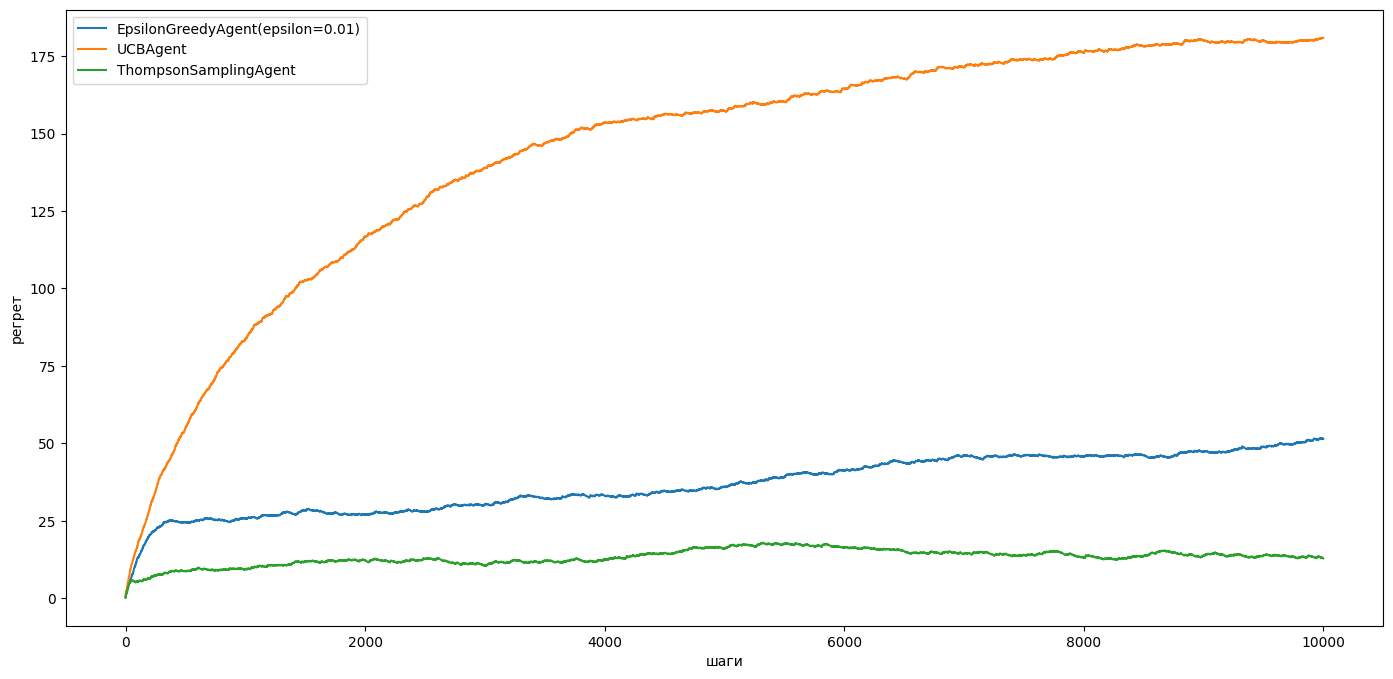

CPU times: user 6 s, sys: 350 ms, total: 6.35 s
Wall time: 6.06 s


In [8]:
%%time
np.random.seed(SEED)

agents = [EpsilonGreedyAgent(), UCBAgent(), ThompsonSamplingAgent()]

plot_regret(BernoulliBandit(), agents, n_steps=10000, n_trials=10)

## Свой агент

In [9]:
class DriftingBandit(BernoulliBandit):
    def __init__(self, n_actions=5, gamma=.01):
        """
        Идея взята из https://github.com/iosband/ts_tutorial
        """
        super().__init__(n_actions)

        self._gamma = gamma

        self._successes = None
        self._failures = None
        self._steps = 0

        self.reset()

    def reset(self):
        self._successes = np.zeros(self.action_count) + 1.
        self._failures = np.zeros(self.action_count) + 1.
        self._steps = 0

    def step(self):
        action = np.random.randint(self.action_count)
        reward = self.pull(action)
        self._step(action, reward)

    def _step(self, action, reward):
        self._successes = self._successes * (1 - self._gamma) + self._gamma
        self._failures = self._failures * (1 - self._gamma) + self._gamma
        self._steps += 1

        self._successes[action] += reward
        self._failures[action] += 1. - reward

        self._probs = np.random.beta(self._successes, self._failures)

Обратите внимание на вероятности наград, изменяющиеся со временем:

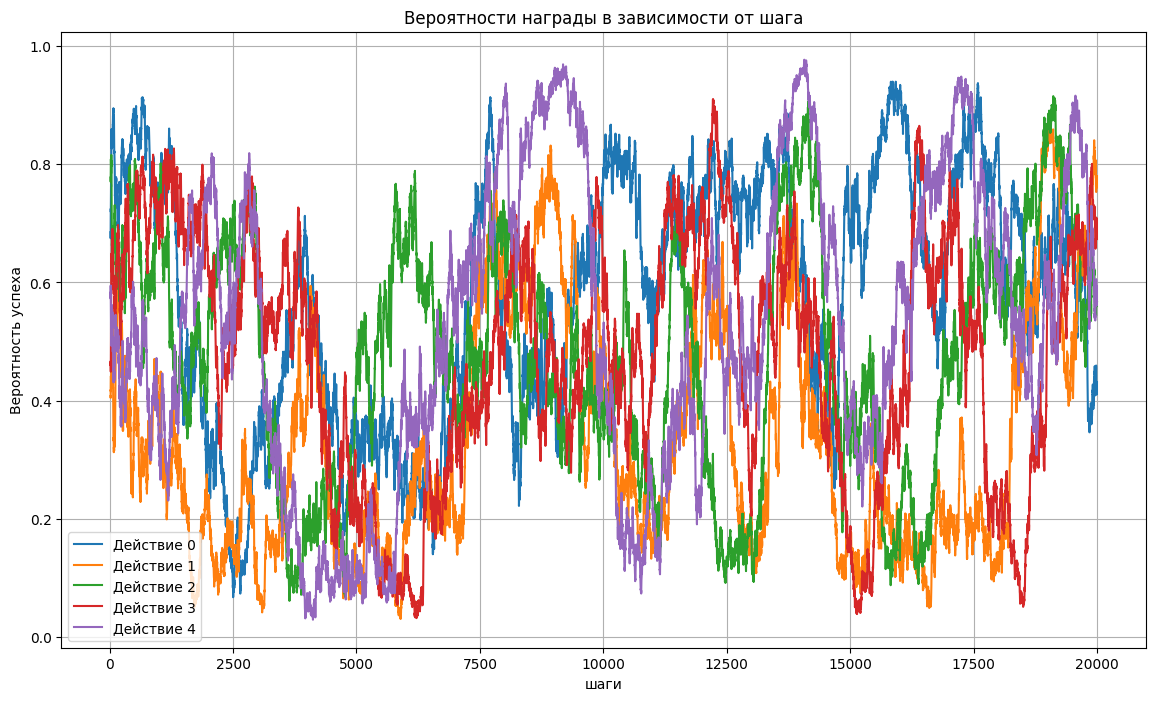

CPU times: user 589 ms, sys: 58.3 ms, total: 647 ms
Wall time: 600 ms


In [10]:
%%time
np.random.seed(SEED)


drifting_env = DriftingBandit(n_actions=5)

drifting_probs = []
for i in range(20000):
    drifting_env.step()
    drifting_probs.append(drifting_env._probs)

plt.figure(figsize=(14, 8))
plt.plot(pd.DataFrame(drifting_probs).rolling(window=20).mean())

plt.xlabel("шаги")
plt.ylabel("Вероятность успеха")
plt.title("Вероятности награды в зависимости от шага")
plt.legend(["Действие {}".format(i) for i in range(drifting_env.action_count)])
plt.grid()
plt.show()

**Задача** &mdash; создать агента, который будет работать лучше каждой рассмотренной выше стационарной стратегии.

In [11]:
class YourAgent(AbstractAgent):
    def __init__(self, gamma=0.01):
        self._decay_factor = 1.0 - gamma
        self._initial_alpha = 1.0
        self._initial_beta = 1.0

    def init_actions(self, n_actions):
        self._successes = np.full(n_actions, self._initial_alpha)
        self._failures = np.full(n_actions, self._initial_beta)
        self._total_pulls = 0

    def get_action(self):
        sampled_theta = np.random.beta(self._successes, self._failures)
        max_theta = np.max(sampled_theta)
        best_actions = np.where(sampled_theta == max_theta)[0]
        return np.random.choice(best_actions)

    def update(self, action, reward):
        """
        Учёт полученной награды в результате совершённого действия и обновление внутренних параметров агента
        :тип данных action: int
        :тип данных reward: int
        """
        self._total_pulls += 1

        self._successes *= self._decay_factor
        self._failures *= self._decay_factor

        self._successes = np.maximum(self._successes, self._initial_alpha / 10)
        self._failures = np.maximum(self._failures, self._initial_beta / 10)

        if reward == 1:
            self._successes[action] += 1
        else:
            self._failures[action] += 1

    @property
    def name(self):
        return self.__class__.__name__ + "(decay_factor={})".format(self._decay_factor)

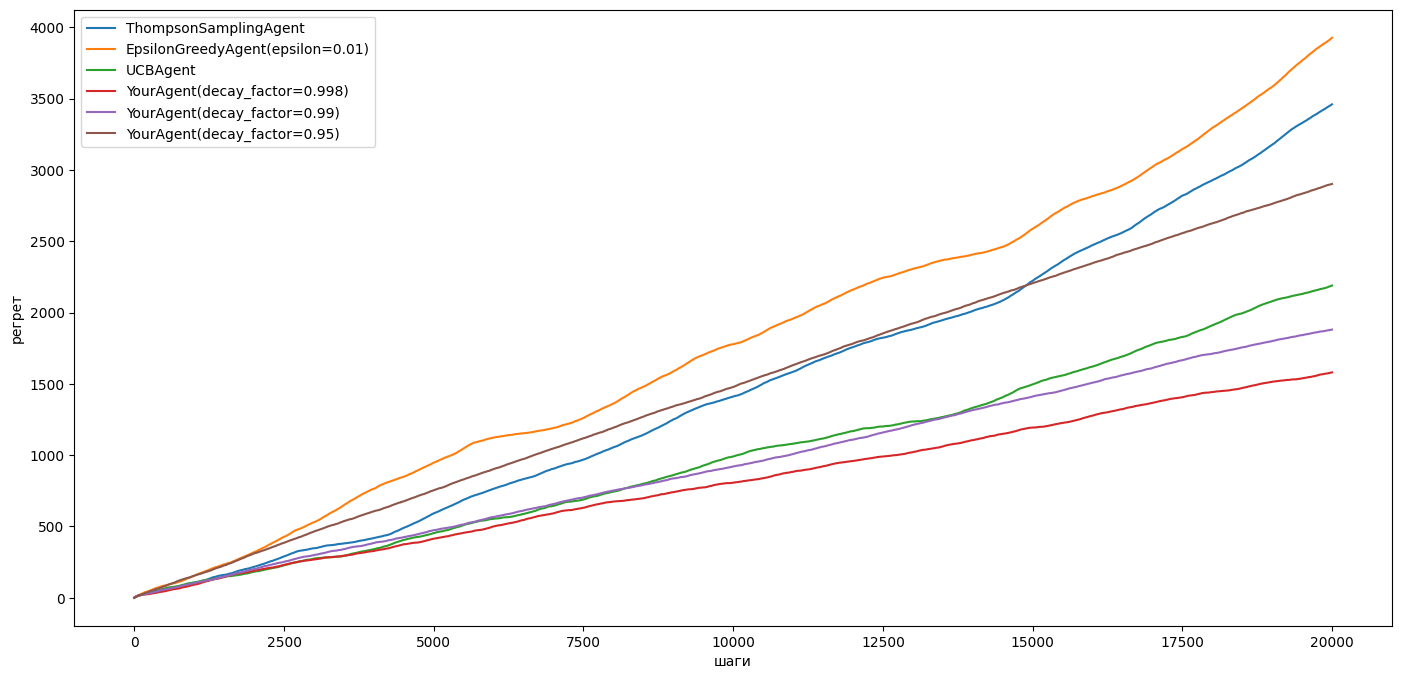

CPU times: user 28.1 s, sys: 183 ms, total: 28.3 s
Wall time: 28.3 s


In [12]:
%%time
np.random.seed(SEED)

drifting_agents = [
    ThompsonSamplingAgent(),
    EpsilonGreedyAgent(),
    UCBAgent(),
    YourAgent(gamma=0.002),
    YourAgent(),
    YourAgent(gamma=0.05),
]

plot_regret(DriftingBandit(), drifting_agents, n_steps=20000, n_trials=10)

# Исследование среды в MDP

### Симулятор Водолаза <font color="green" size=6> (5 баллов) &mdash; основное задание, (4 балла) &mdash; бонусное задание </font>

1. <font color="green"> [1 балл] </font> Reward Shaping
2. <font color="green"> [2 балла] </font> Uncertainty with forward dynamics 
3. <font color="green"> [2 балла] </font> Uncertainty with reverse dynamics
4. <font color="green"> [2 бонусных балла] </font> Intrinsic Curiosity Module algorithm
5. <font color="green"> [2 бонусных балла] </font> Random Network Distillation

Deep Sea реализован в виде сетки `N×N` с one-hot кодированиям состояния.
Агент (далее водолаз Юра) начинает каждый эпизод в верхнем левом углу сетки и спускается на одну строку за таймстеп.
Каждый эпизод завершается через `N` шагов, когда водолаз достигает нижней строки (то есть дна моря).
Юра &mdash; начинающий дайвер, поэтому ему тяжело ориентироваться в пучинах моря, что учитывается особенностью среды:
в каждом состоянии существует случайное, но фиксированное отображение между действиями $A\in \{0,1\}$ и переходами «влево» и «вправо».
На каждом таймстепе существует небольшая стоимость $r=-0,01/N$ для перехода вправо и $r = 0$ для перехода влево.
Однако, если водолаз переходит направо на каждом временном шаге эпизода, то в конце он получает дополнительное вознаграждение $+1$ &mdash; сундук с сокровищами.

Наша задача помочь водолазу Юре добраться до сокровища. Однако, движение вправо (наискорейший приход к сундуку) является невыгодным действием до самого конца эпизода и, казалось бы,
наш уважаемый водолаз не должен туда плыть. Как же с этим бороться?

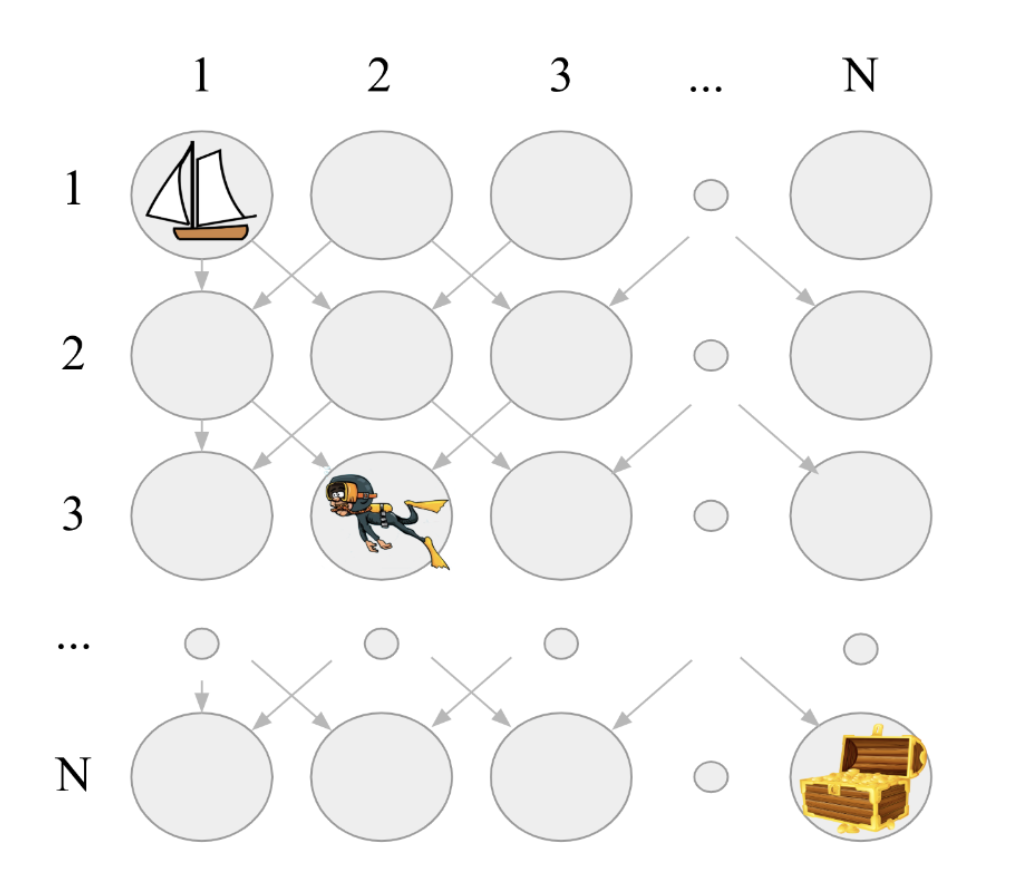


Среда про водолаза не является стандартной средой библиотеки `gymnasium`. Она (и ещё куча других необычных сценариев) была реализованна энтузиастами из Google. Оригинальный репозиторий можно найти
[по этой ссылке](https://github.com/google-deepmind/bsuite). Чтобы воспользоваться этим чудом трудов американских коллег необходимо скачать их библиотеку `bsuite`, а затем с помощью обёртки над `gymnasium` по
идентификационному номеру среды импортировать её. Таким образом можно сохранить интерфейс `gymnasium` взаимодействия со средой, и никому не придется переписывать код. Также ученые из *Америки*
предоставляют доступ к бесплатному [гайду](https://colab.research.google.com/drive/1rU20zJ281sZuMD1DHbsODFr1DbASL0RH) в Google Colab.


In [13]:

import gymnasium as gym
import bsuite
from bsuite.utils import gym_wrapper
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from time import sleep
from tqdm import tqdm
from IPython.display import clear_output

from q_learning_agent import QLearningAgent
from replay_buffer import ReplayBuffer
from bsuite.utils import gym_wrapper

Чтобы загрузить нужную среду `bsuite` нужно знать её `bsuite_id`. Чтобы получить список всех возможных сред и их `id` можно распечатать следующий код.

In [14]:
from bsuite import sweep

print("Все возможные значения bsuite_id:", sweep.SWEEP)
for _env in sweep.SWEEP:
    print(_env)
print(datetime.now())

Все возможные значения bsuite_id: ('bandit/0', 'bandit/1', 'bandit/2', 'bandit/3', 'bandit/4', 'bandit/5', 'bandit/6', 'bandit/7', 'bandit/8', 'bandit/9', 'bandit/10', 'bandit/11', 'bandit/12', 'bandit/13', 'bandit/14', 'bandit/15', 'bandit/16', 'bandit/17', 'bandit/18', 'bandit/19', 'bandit_noise/0', 'bandit_noise/1', 'bandit_noise/2', 'bandit_noise/3', 'bandit_noise/4', 'bandit_noise/5', 'bandit_noise/6', 'bandit_noise/7', 'bandit_noise/8', 'bandit_noise/9', 'bandit_noise/10', 'bandit_noise/11', 'bandit_noise/12', 'bandit_noise/13', 'bandit_noise/14', 'bandit_noise/15', 'bandit_noise/16', 'bandit_noise/17', 'bandit_noise/18', 'bandit_noise/19', 'bandit_scale/0', 'bandit_scale/1', 'bandit_scale/2', 'bandit_scale/3', 'bandit_scale/4', 'bandit_scale/5', 'bandit_scale/6', 'bandit_scale/7', 'bandit_scale/8', 'bandit_scale/9', 'bandit_scale/10', 'bandit_scale/11', 'bandit_scale/12', 'bandit_scale/13', 'bandit_scale/14', 'bandit_scale/15', 'bandit_scale/16', 'bandit_scale/17', 'bandit_scale

В ячейке ниже мы загружаем среду `deep_sea` версии `0`. Каждая версия этой среды отлечается размерами игрового поля.

In [15]:
raw_env = bsuite.load_from_id(bsuite_id="deep_sea/0")
env = gym_wrapper.GymFromDMEnv(raw_env)
print(
    "Начальноe состояние водолаза:",
    _ := env.reset(),
    f'Размер сетки: {"x".join(str(tmp) for tmp in _.shape)}',
    sep="\n",
)

Loaded bsuite_id: deep_sea/0.
Начальноe состояние водолаза:
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Размер сетки: 10x10


#### Epsilon-greedy q-learning

In [16]:
def get_state_number(s):
    return np.argmax(s.flatten())


def test_agent(agent, greedy=True, delay=.5):
    v = get_all_states_value(agent)
    s = env.reset()
    done = False
    while not done:
        fig, ax = plt.subplots(ncols=2)
        ax[0].imshow(s)
        ax[0].set_title("Состояние")
        im = ax[1].imshow(v)
        plt.colorbar(im)
        ax[1].set_title("V-функция ценности")
        clear_output(True)
        plt.show()
        s = get_state_number(s)
        if greedy:
            a = agent.get_best_action(s)
        else:
            a = agent.get_action(s)

        s, r, terminated, truncated = env.step(a)
        done = terminated or truncated
        sleep(delay)


def get_all_states_value(agent):
    s_shape = env.observation_space.shape
    s_shape_flatten = np.prod(s_shape)
    v = np.zeros(s_shape_flatten)
    for i in range(s_shape_flatten):
        v[i] = agent.get_value(i)
    v = v.reshape(s_shape)
    return v


def to_one_hot(x, ndims):
    """функция-помощник: берёт целочисленный вектор и преобразует в 1-hot матрицу."""
    x = x.long().view(-1, 1)
    x = torch.zeros(x.size()[0], ndims).scatter_(1, x, 1)
    return x

In [17]:
agent = QLearningAgent(
    epsilon=1,
    alpha=.5,
    discount=1,
    get_legal_actions=lambda s: range(env.action_space.n),
)

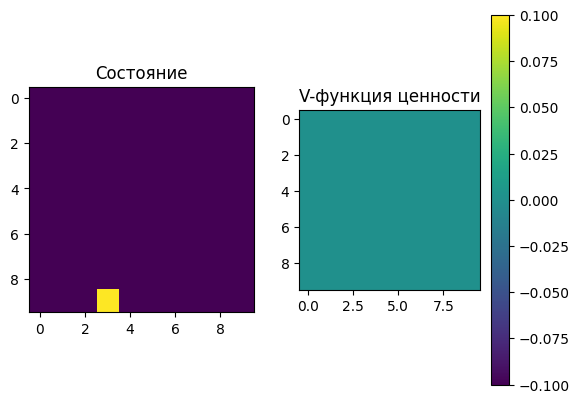

In [18]:
test_agent(agent, greedy=True)

Пока что наш водолаз не справляется с поставленной задачей, потренируем его нырять как следует (увеличим ему интерес к исследованиям).

In [19]:
for i in range(5000):
    s = env.reset()
    done = False
    while not done:
        i_s = get_state_number(s)
        a = agent.get_action(i_s)
        s_next, r, terminated, truncated = env.step(a)
        done = terminated or truncated
        i_s_next = get_state_number(s_next)
        agent.update(i_s, a, r, i_s_next, terminated)
        s = s_next

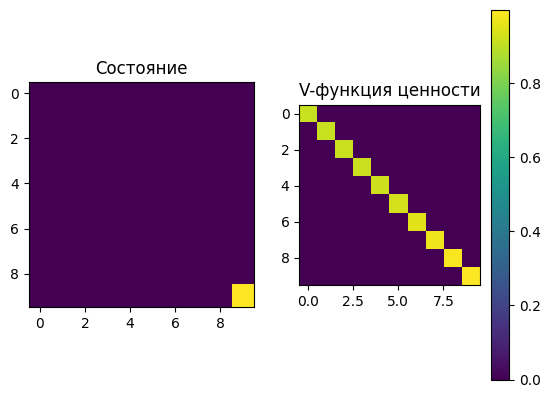

In [20]:
test_agent(agent)

И вот, водолаз нашёл свой клад! Ура? Всё? Победа?

Ну, конечно, же нет. Выбросим водолаза в море поглубже.

In [21]:
raw_env = bsuite.load_from_id(bsuite_id="deep_sea/20")
env = gym_wrapper.GymFromDMEnv(raw_env)
print(
    "Начальноe состояние водолаза:",
    _ := env.reset(),
    f'Размер сетки: {"x".join(str(tmp) for tmp in _.shape)}',
    sep="\n",
)

Loaded bsuite_id: deep_sea/20.
Начальноe состояние водолаза:
[[1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Размер сетки: 50x50


In [22]:
agent = QLearningAgent(
    epsilon=1,
    alpha=.5,
    discount=1,
    get_legal_actions=lambda s: range(env.action_space.n),
)

for i in range(5000):
    s = env.reset()
    done = False
    while not done:
        i_s = get_state_number(s)
        a = agent.get_action(i_s)
        s_next, r, terminated, truncated = env.step(a)
        done = terminated or truncated
        i_s_next = get_state_number(s_next)
        agent.update(i_s, a, r, i_s_next, terminated)
        s = s_next

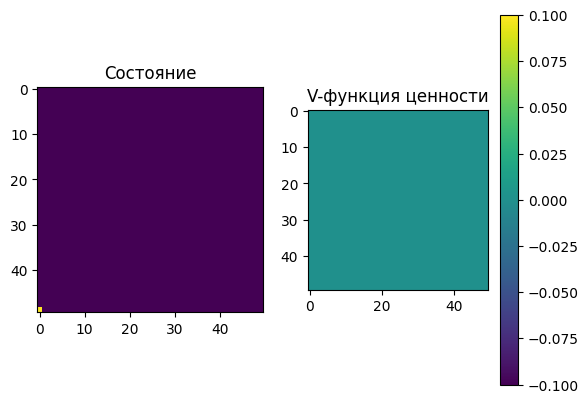

In [23]:
test_agent(agent)

Вот и всё, приплыли, что называется. Давайте, подсказывайте. Заполните ячейки ниже и помогите Юре найти сокровища!

**ВОПРОС**: почему такое поведение мы наблюдаем на маленькой среде? Что меняется при увеличении размеров среды? <font color="green">(0.1 балла)</font>

**ОТВЕТ**: 
я не знаю :с 
Думал может он не успевает исследовать все пути, но у него случайное блуждание 100% он за 5000 попыток возможно просто не нашел путь до сокровища. (попробовал уменьшить дискаунт и уменьшить шанс случайного блуждания). Не нахожу обоснований для своих гипотез. 

**ОТВЕТ:** ПОТОМУ ЧТО ОН ТЕРЯЕТ БОЛЬШЕ НАГРАДЫ ЧЕМ ЗАРАБОТАЕТ ЕСЛИ НАЙДЕТ КЛАД ! 

In [24]:
agent = QLearningAgent(
    epsilon=0.5,
    alpha=.5,
    discount=0.99,
    get_legal_actions=lambda s: range(env.action_space.n),
)

for i in range(5000):
    s = env.reset()
    done = False
    while not done:
        i_s = get_state_number(s)
        a = agent.get_action(i_s)
        s_next, r, terminated, truncated = env.step(a)
        done = terminated or truncated
        i_s_next = get_state_number(s_next)
        agent.update(i_s, a, r, i_s_next, terminated)
        s = s_next

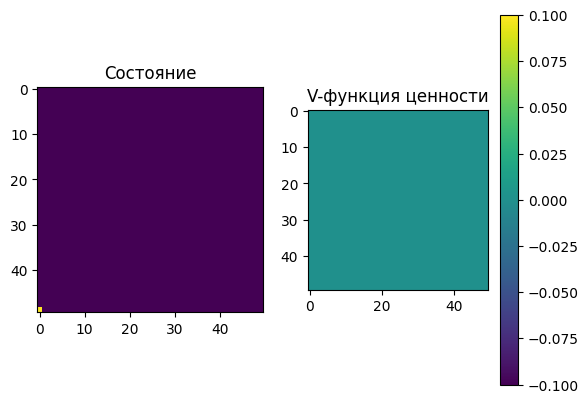

In [25]:
test_agent(agent)

#### Reward Shaping

In [26]:
class BaseIntrinsicRewardModule(nn.Module):
    def __init__(self):
        super().__init__()

    def get_intrinsic_reward(self, state, action, next_state):
        return 0.

    def get_loss(self, state_batch, action_batch, next_state_batch):
        pass

In [27]:
def train_with_reward(
    env,
    agent,
    reward_module,
    n_episodes=100,
    update_reward_period=100,
    batch_size=100,
    n_iter=10,
):
    buffer = ReplayBuffer(size=int(1e6))

    if list(reward_module.parameters()):
        optimizer = torch.optim.Adam(reward_module.parameters())
    else:
        optimizer = None

    losses = []
    s = env.reset()

    for i in range(n_episodes):
        done = False

        while not done:
            i_s = get_state_number(s)
            a = agent.get_action(i_s)
            s_next, r, terminated, truncated = env.step(a)
            done = terminated or truncated
            i_s_next = get_state_number(s_next)

            state_t = torch.tensor(s).float().view(1, -1)
            action_t = torch.tensor(a).float().view(1, -1)
            next_state_t = torch.tensor(s_next).float().view(1, -1)

            r_intr = reward_module.get_intrinsic_reward(state_t, action_t, next_state_t)
            r += r_intr

            agent.update(i_s, a, r, i_s_next, terminated)
            buffer.add(s, a, r, s_next, terminated)

            s = s_next

        if (i + 1) % update_reward_period == 0 and optimizer is not None:

            for _ in range(n_iter):
                optimizer.zero_grad()
                state_batch, action_batch, _, next_state_batch, _ = buffer.sample(
                    batch_size
                )

                state_tensor = torch.tensor(state_batch).float().flatten(1, 2)
                action_tensor = torch.tensor(action_batch).float().view(-1, 1)
                next_state_tensor = torch.tensor(next_state_batch).float().flatten(1, 2)

                loss = reward_module.get_loss(
                    state_tensor, action_tensor, next_state_tensor
                )
                loss.backward()
                optimizer.step()
                losses.append(loss.item())

            fig, ax = plt.subplots(ncols=2)
            ax[0].set_title("V-функция ценности после итерации: %d" % i)
            im = ax[0].imshow(get_all_states_value(agent))
            ax[1].plot(losses)
            ax[1].set_xlabel("шаг")
            ax[1].set_ylabel("значение функции потерь")
            ax[1].set_title("Random Network Distillation функция потерь")
            clear_output(True)
            plt.show()

In [28]:
class GoRightReward(BaseIntrinsicRewardModule):
    def __init__(self, reward_scale=.01):
        super().__init__()
        self.reward_scale = reward_scale

    def get_intrinsic_reward(self, state, action, next_state):
        # Код Вашей реализации поместите здесь

        state_idx = torch.argmax(state, dim=1).item()
        next_state_idx = torch.argmax(next_state, dim=1).item()

        current_col = state_idx
        next_col = next_state_idx

        intrinsic_reward = 0.0
        if next_col > current_col:
            intrinsic_reward = self.reward_scale

        elif next_col < current_col:
            intrinsic_reward = -self.reward_scale

        return intrinsic_reward

In [29]:
agent = QLearningAgent(
    epsilon=.1,
    alpha=.5,
    discount=.9,
    get_legal_actions=lambda s: range(env.action_space.n),
)

go_right = GoRightReward()

train_with_reward(env, agent, go_right, n_episodes=500)

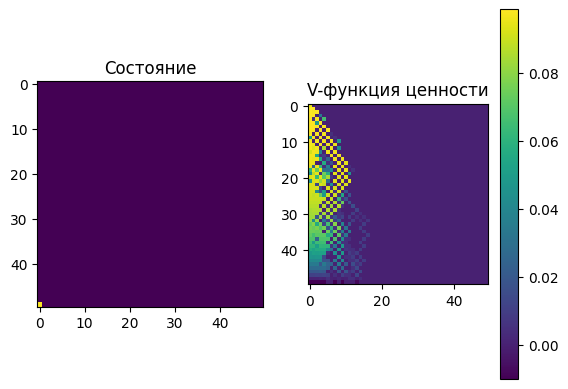

In [30]:
test_agent(agent, greedy=True)

#### Curiosity-driven Exploration

Добавим Водолазу Юре любопытства. Если вы затрудняетесь с заполнением кода ниже, то, пожалуйста, обратите внимание на главу 8.2 [учебника курса](https://arxiv.org/pdf/2201.09746).

In [31]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size),
        )

        def init_weights(tensor):
            if isinstance(tensor, nn.Linear):
                nn.init.xavier_uniform_(tensor.weight)

        self.layers.apply(init_weights)

    def forward(self, x):
        return self.layers(x)

##### Uncertainty with forward dynamics (2 балла)

Пусть внутри агента строится модель прямой динамики:
$$\mathbb{E}_{s,a,s'} \left[\|f(s, a) - s'\|^2_2\right] \to \min_f$$
Тогда во время очередного обучающего эпизода ошибка модели $f$ на каждом шаге может рассматриваться как любопытство и задавать внутреннюю мотивацию агента:
$$
r^{\mathrm{intr}}(s, a, s') := \|f(s, a) - s'\|^2_2
$$

Такой сигнал будет мотивировать агента искать не новые области, а те, в которых он не понимает, как работает среда. В некоторых средах такой сигнал, однако, может привести к прокрастинации (в частности к проблеме шумного телевизора)

In [ ]:
class ForwardDynamics(BaseIntrinsicRewardModule):
    def __init__(self, states_size, actions_size, hidden_size, alpha=.1):
        super().__init__()
        self.module = MLP(
            actions_size + states_size,
            hidden_size,
            states_size
        )
        self.alpha = alpha
        self.mean_reward = 0
        self.mse = nn.MSELoss()

    def forward(self, s, a):
        sa = torch.cat([s, a], dim=-1)
        return s + self.module(sa)

    def get_intrinsic_reward(self, state, action, next_state):
        with torch.no_grad():
            r = self.get_loss(state, action, next_state)
            r_centered = r - self.mean_reward
            self.mean_reward = self.alpha * (r) + (1 - self.alpha) * self.mean_reward
            return r_centered

    def get_loss(self, state_batch, action_batch, next_state_batch):
        predicted_next_state_batch = self.forward(state_batch, action_batch)
        loss = self.mse(predicted_next_state_batch, next_state_batch)
        return loss

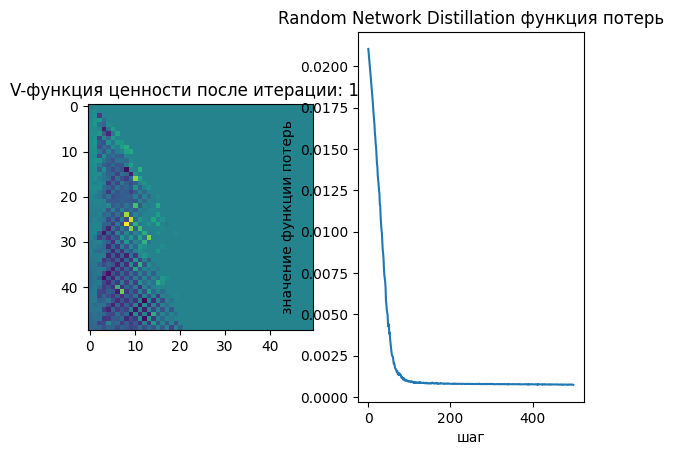

In [33]:
agent = QLearningAgent(
    epsilon=.1,
    alpha=.5,
    discount=.9,
    get_legal_actions=lambda s: range(env.action_space.n),
)

forward_dynamics = ForwardDynamics(np.prod(env.observation_space.shape), 1, 16)

train_with_reward(
    env,
    agent,
    forward_dynamics,
    n_episodes=2000,
    update_reward_period=100,
    batch_size=100,
    n_iter=25,
)

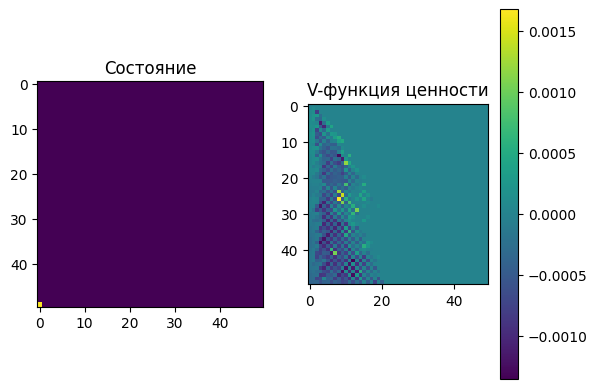

In [34]:
test_agent(agent)

##### Uncertainty with reverse dynamics

Советуем обратить внимание на [статью](https://arxiv.org/pdf/1705.05363.pdf)

Модель, аппроксимирующая $p(a | s, s')$, называется *моделью обратной динамики* (inverse dynamics model)

$$
p(a \mid s, s') = \frac{p(s' \mid s, a)\pi(a \mid s)}{\int\limits_{\mathcal{A}} p(s' \mid s, a)\pi(a \mid s) d a}
$$


In [58]:
class InverseDynamics(BaseIntrinsicRewardModule):
    def __init__(self, states_size, n_actions, hidden_size, alpha=0.1):
        super().__init__()
        self.module = MLP(
            states_size * 2,
            hidden_size,
            n_actions
        )
        self.n_actions = n_actions
        self.alpha = alpha
        self.mean_reward = 0.0

    def forward(self, s, s_next):
        ss_next = torch.cat([s, s_next], dim=-1)
        return self.module(ss_next)

    def get_intrinsic_reward(self, state, action, next_state):
        with torch.no_grad():
            action_logits_pred = self.forward(state, next_state)
            action_probs_pred = torch.softmax(action_logits_pred, dim=-1)

            true_action_idx = action.long().item()
            prob_of_true_action = action_probs_pred[0, true_action_idx].item()

            r = (1.0 - prob_of_true_action)

            r_centered = r - self.mean_reward
            self.mean_reward = self.alpha * r + (1 - self.alpha) * self.mean_reward
            return r_centered

    def get_loss(self, state_batch, action_batch, next_state_batch):
        action_logits_batch_pred = self.forward(state_batch, next_state_batch)
        true_actions_indices = action_batch.long().squeeze()

        loss = torch.nn.functional.cross_entropy(action_logits_batch_pred, true_actions_indices)
        return loss

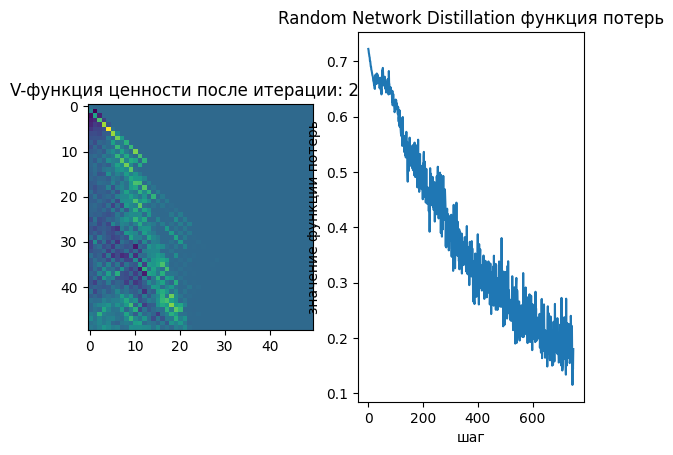

In [59]:
agent = QLearningAgent(
    epsilon=.1,
    alpha=.5,
    discount=.9,
    get_legal_actions=lambda s: range(env.action_space.n),
)

inverse_dynamics = InverseDynamics(
    np.prod(env.observation_space.shape), env.action_space.n, 16
)

train_with_reward(
    env,
    agent,
    inverse_dynamics,
    n_episodes=3000,
    update_reward_period=100,
    batch_size=100,
    n_iter=25,
)

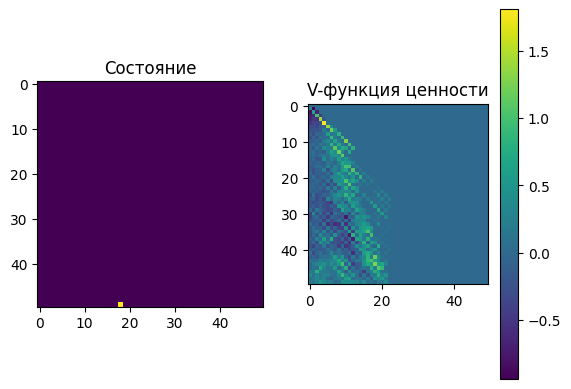

In [60]:
test_agent(agent)

##### Бонус: Intrinsic Curiosity Module (ICM) algorithm


Свойство модели обратной динамики наводит на мысль, как можно построить защиту от шумных телевизоров. Для этого мы возьмём описание состояний и "почистим" их от шумных телевизоров при помощи фильтра $\phi(s)$, который переведёт описание состояния в некоторое латентное пространство, хранящее лишь частичную информацию о входе. А дальше модель прямой динамики построим в таком "отфильтрованном" латентном представлении:
$$
\mathbb{E}_{s, a, s'} \left[\|f(\phi(s), a) - \phi(s')\|^2_2\right] \to \min_{f} \quad \quad\quad(\star)
$$
Авторы алгоритма ICM предлагают обе модели обучать совместно, то есть в частности оптимизировать $(\star)$ по параметрам фильтра $\phi$. Итого модель ICM выглядит следующим образом (рассмотрим для примера случай непрерывных действий):
$$\mathbb{E}_{s, a, s'} \left[ \|g(\phi(s), \phi(s')) - a\|^2_2 + \alpha \|f(\phi(s), a) - \phi(s')\|^2_2 \right] \to \min_{f, g, \phi}$$
где $s, a, s'$ &mdash; произвольные тройки из любого буфера, $\alpha$ &mdash; масштабирующий гиперпараметр.

In [61]:
class Embedder(nn.Module):
    def __init__(self, states_size, embedding_size, hidden_size):
        super().__init__()
        self.module = MLP(
            states_size,
            hidden_size,
            embedding_size
        )

    def forward(self, s):
        return self.module(s)

class ICMModule(BaseIntrinsicRewardModule):
    def __init__(self, states_size, n_actions, hidden_size, embedding_size, beta_param=0.2, reward_scale=0.01, alpha_reward_norm=0.05):
        super().__init__()
        # Код Вашей реализации поместите здесь
        self.embedder = Embedder(states_size, embedding_size, hidden_size)
        self.inverse_model = MLP(embedding_size * 2, hidden_size, n_actions)
        self.forward_model = MLP(embedding_size + n_actions, hidden_size, embedding_size)

        self.mse = nn.MSELoss()
        self.cross_entropy = nn.CrossEntropyLoss()

        self.n_actions = n_actions
        self.beta_param = beta_param
        self.reward_scale = reward_scale
        self.alpha_reward_norm = alpha_reward_norm
        self.mean_intrinsic_reward = 0.0

    def get_intrinsic_reward(self, state, action, next_state):
        with torch.no_grad():
            phi_s = self.embedder(state)
            phi_s_next_true = self.embedder(next_state)

            action_onehot = to_one_hot(action.long(), self.n_actions)

            phi_s_next_pred = self.forward_model(torch.cat([phi_s, action_onehot], dim=-1))

            r_intr_unscaled = self.mse(phi_s_next_pred, phi_s_next_true)


            r_intr = r_intr_unscaled * self.reward_scale
            r_intr_centered = r_intr - self.mean_intrinsic_reward
            self.mean_intrinsic_reward = self.alpha_reward_norm * r_intr + (1 - self.alpha_reward_norm) * self.mean_intrinsic_reward
            return r_intr_centered

    def get_loss(self, state_batch, action_batch, next_state_batch):
        phi_s_batch = self.embedder(state_batch)
        phi_s_next_batch = self.embedder(next_state_batch)

        action_onehot_true_batch = to_one_hot(action_batch.long(), self.n_actions)
        action_logits_pred_batch = self.inverse_model(torch.cat([phi_s_batch, phi_s_next_batch], dim=-1))
        true_actions_indices = action_batch.long().squeeze()
        loss_inverse = self.cross_entropy(action_logits_pred_batch, true_actions_indices)


        phi_s_next_pred_batch = self.forward_model(torch.cat([phi_s_batch, action_onehot_true_batch], dim=-1))
        loss_forward = self.mse(phi_s_next_pred_batch, phi_s_next_batch)

        total_loss = (1 - self.beta_param) * loss_inverse + self.beta_param * loss_forward
        return total_loss

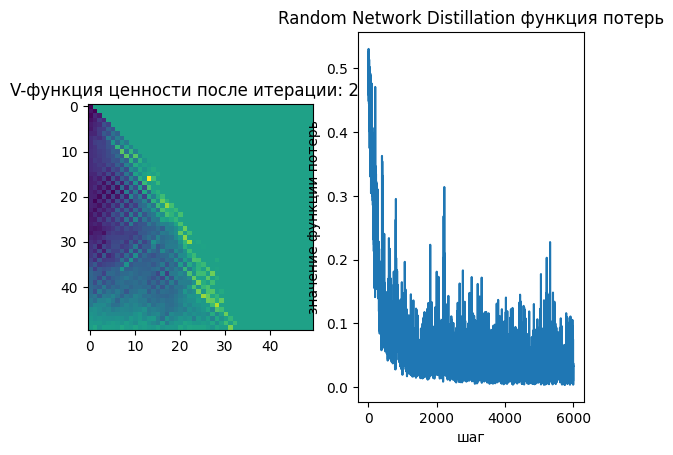

In [64]:
agent = QLearningAgent(
    epsilon=.1,
    alpha=.5,
    discount=1,
    get_legal_actions=lambda s: range(env.action_space.n),
)

icm = ICMModule(
    states_size=np.prod(env.observation_space.shape),
    n_actions=env.action_space.n,
    hidden_size=16,
    embedding_size=10,
)

train_with_reward(
    env,
    agent,
    icm,
    n_episodes=3000,
    update_reward_period=100,
    batch_size=100,
    n_iter=200,
)

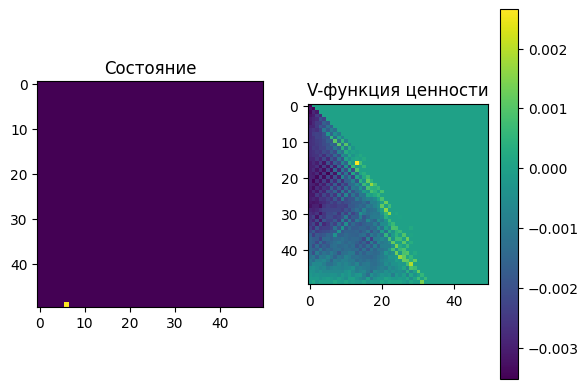

In [65]:
test_agent(agent)

#### Бонус: Random network distillation

In [77]:
class RandomNetworkDistilationModule(BaseIntrinsicRewardModule):
    def __init__(self, states_size, features_size, hidden_size, reward_scale=1, alpha_reward_norm=0.05):
        super().__init__()
        self.predictor_net = MLP(states_size, hidden_size, features_size)
        self.target_net = MLP(states_size, hidden_size, features_size)
        for param in self.target_net.parameters():
            param.requires_grad = False

        self.mse = nn.MSELoss()

        self.reward_scale = reward_scale
        self.alpha_reward_norm = alpha_reward_norm
        self.mean_intrinsic_reward = 0.0

    def get_intrinsic_reward(self, state, action, next_state):
        with torch.no_grad():
            pred_features = self.predictor_net(next_state)
            target_features = self.target_net(next_state)


            r_intr_unscaled = self.mse(pred_features, target_features)

            r_intr = r_intr_unscaled * self.reward_scale
            r_intr_centered = r_intr - self.mean_intrinsic_reward
            self.mean_intrinsic_reward = self.alpha_reward_norm * r_intr + (1 - self.alpha_reward_norm) * self.mean_intrinsic_reward
            return r_intr_centered

    def get_loss(self, state_batch, action_batch, next_state_batch):
        pred_features_batch = self.predictor_net(next_state_batch)
        with torch.no_grad():
            target_features_batch = self.target_net(next_state_batch)

        loss = self.mse(pred_features_batch, target_features_batch)
        return loss

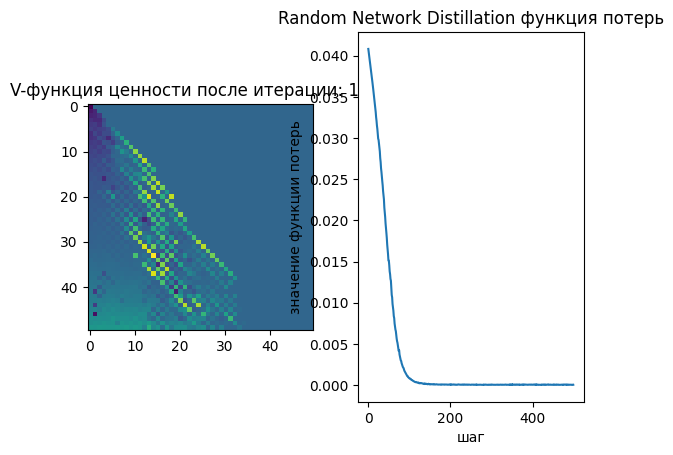

In [81]:
agent = QLearningAgent(
    epsilon=.1,
    alpha=.5,
    discount=.9,
    get_legal_actions=lambda s: range(env.action_space.n),
)

rnd = RandomNetworkDistilationModule(
    np.prod(env.observation_space.shape), np.prod(env.observation_space.shape), 16, 100
)

train_with_reward(
    env,
    agent,
    rnd,
    n_episodes=2000,
    update_reward_period=100,
    batch_size=100,
    n_iter=25,
)

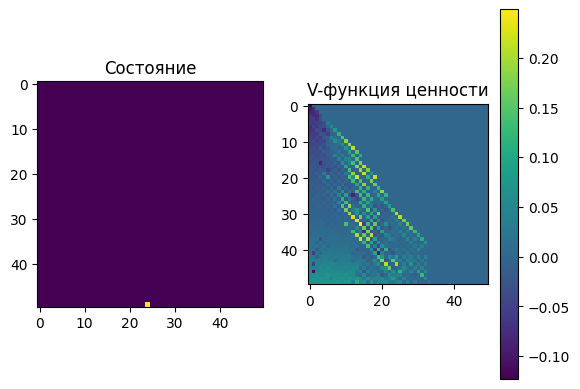

In [82]:
test_agent(agent)

### На пути к мечте <font color="green" size=6> (2 балла) &mdash; основное задание</font>

1. <font color="green"> [2 балла] </font> Posterior sampling RL

Следующая задача, "river flow", демонстрирует важность исследования среды на примере Марковского процесса принятия решений.

Простой мальчишка Илья из Митино захотел воплотить свою мечту в жизнь и переехать жить в Америку штат Маслачусетс. Но вот незадача! Визу
в США ему не дают. Но наш герой не сдаётся, он прилетел в Мексику и хочет переплыть знаменитую реку Рио-Гранде с сильным течением. Помогите Илье
испольнить его желание!

Илья движется прямо против течения реки и пытается добраться до её устья. Течение реки очень сильное и движение по течению реки
происходит легко и непринужденно (то есть с вероятностью $1$), потому что Илья может просто наслаждается теплой водой и Мексиканским солнцем, пока река несёт его сама.
А вот двигаться против течения реки у Ильи получается с переменным успехом: с вероятностью $p$ сил у его коротких ножек не хватает и он остаётся на месте,
а с вероятностью $1-p$ ему удается на шаг приблизиться к счастливой жизни.

Радость Илья испытывает в самом начале своего пути ($r = 5 \cdot 10^{-3}$) от того, что можно лежать в воде и ничего не делать и в самом конце,
от того, что теперь ему предстоит провести пару дней в Миграционном Каземате США.

Схематично ситуацию описывает рисунок:

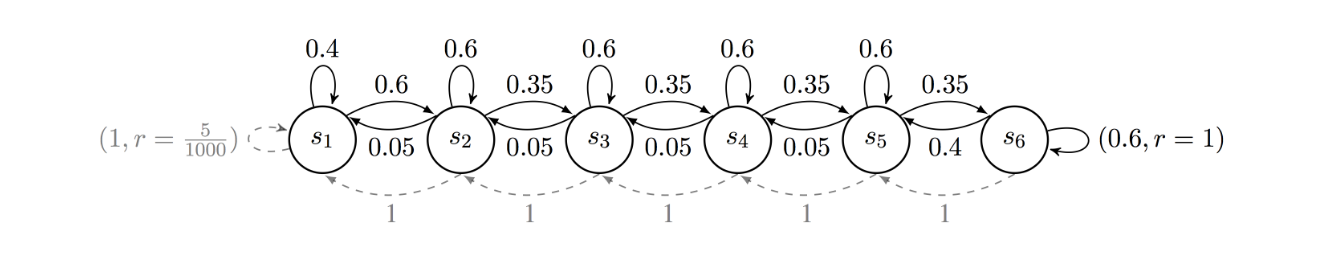

Рисунок взят из https://arxiv.org/abs/1306.0940

Награды и вероятности переходов самому Илье неизвестны, а оптимальная стратегия состоит в том, чтобы идти направо против потока, тогда как легче будет идти налево и получать небольшую награду каждый раз.
Заметим, что эта ситуация очень похожа на ту, которая была у Водолаза Юры в предыдущем сюжете.

In [83]:
class RiverSwimEnv:
    LEFT_REWARD = 5. / 1000
    RIGHT_REWARD = 1.

    def __init__(self, intermediate_states_count=4, max_steps=16):
        self._max_steps = max_steps
        self._current_state = None
        self._steps = None
        self._interm_states = intermediate_states_count
        self.reset()

    def reset(self):
        self._steps = 0
        self._current_state = 1
        return self._current_state, 0., False

    @property
    def n_actions(self):
        return 2

    @property
    def n_states(self):
        return 2 + self._interm_states

    def _get_transition_probs(self, action):
        if action == 0:
            if self._current_state == 0:
                return [0, 1., 0]
            else:
                return [1., 0, 0]

        elif action == 1:
            if self._current_state == 0:
                return [0, .4, .6]
            if self._current_state == self.n_states - 1:
                return [.4, .6, 0]
            else:
                return [.05, .6, .35]
        else:
            raise RuntumeError(
                "Неизвестное действие {}. Максимальное количество действий {}".format(
                    action, self.n_actions
                )
            )

    def step(self, action):
        """
        :параметр action:
        :тип данных action: int
        :возвращает: observation, reward, is_done
        :тип возвращаемых данных: (int, float, bool)
        """
        reward = 0.

        if self._steps >= self._max_steps:
            return self._current_state, reward, True

        transition = np.random.choice(range(3), p=self._get_transition_probs(action))
        if transition == 0:
            self._current_state -= 1
        elif transition == 1:
            pass
        else:
            self._current_state += 1

        if self._current_state == 0:
            reward = self.LEFT_REWARD
        elif self._current_state == self.n_states - 1:
            reward = self.RIGHT_REWARD

        self._steps += 1
        return self._current_state, reward, False

Ниже предлагается реализовать Q-обучение агента с $\varepsilon$-жадной стратегией и посмотреть на производительность данного решения.

In [91]:
class QLearningAgent:
    def __init__(self, n_states, n_actions, lr=.2, gamma=.95, epsilon=.1):
        self._gamma = gamma
        self._epsilon = epsilon
        self._q_matrix = np.zeros((n_states, n_actions))
        self._lr = lr

    def get_action(self, state):
        if np.random.random() < self._epsilon:
            return np.random.randint(0, self._q_matrix.shape[1])
        else:
            return np.argmax(self._q_matrix[state])

    def get_q_matrix(self):
        """Используется для визуализации политики"""

        return self._q_matrix

    def start_episode(self):
        """Используется в PSRL агенте"""
        pass

    def update(self, state, action, reward, next_state):
        """
        Метод для обновления значения Q-функции ценности:
           Q(s,a) := (1 - alpha) * Q(s,a) + alpha * (r + gamma * V(s'))
        """
        V_s = np.max(self._q_matrix[next_state])
        self._q_matrix[state, action] = (1 - self._lr) * self._q_matrix[state, action] + self._lr * reward + self._gamma * V_s

In [92]:
def train_mdp_agent(agent, env, n_episodes):
    episode_rewards = []

    for ep in range(n_episodes):
        state, ep_reward, is_done = env.reset()
        agent.start_episode()
        while not is_done:
            action = agent.get_action(state)

            next_state, reward, is_done = env.step(action)
            agent.update(state, action, reward, next_state)

            state = next_state
            ep_reward += reward

        episode_rewards.append(ep_reward)
    return episode_rewards

/var/folders/_6/2rn_7pxd0753xpzw6bky5hnr0000gn/T/ipykernel_30070/2092143026.py:29: RuntimeWarning: overflow encountered in scalar add
  self._q_matrix[state, action] = (1 - self._lr) * self._q_matrix[state, action] + self._lr * reward + self._gamma * V_s


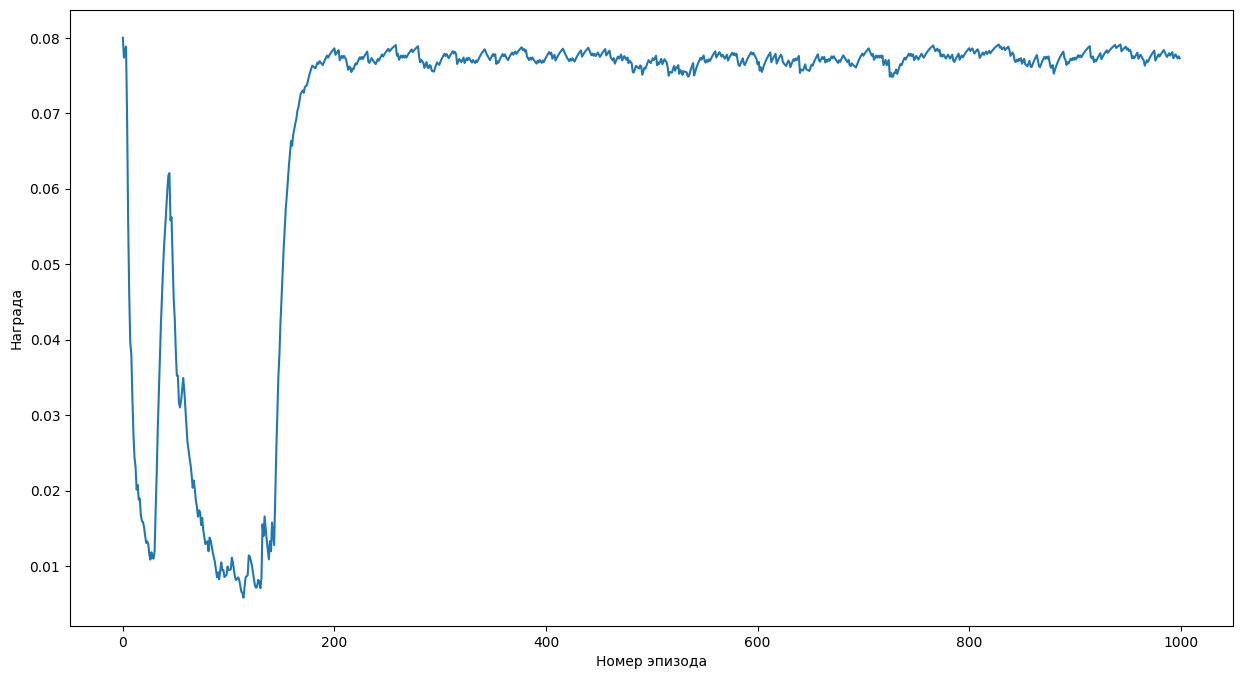

CPU times: user 259 ms, sys: 15.1 ms, total: 274 ms
Wall time: 267 ms


In [94]:
%%time
np.random.seed(SEED)


env = RiverSwimEnv()
agent = QLearningAgent(env.n_states, env.n_actions)
rews = train_mdp_agent(agent, env, 1000)
plt.figure(figsize=(15, 8))

plt.plot(pd.DataFrame.ewm(pd.DataFrame(np.array(rews)), alpha=0.1).mean())
plt.xlabel("Номер эпизода")
plt.ylabel("Награда")
plt.show()

Ниже реализована визуализация решений агента:

In [95]:
def plot_policy(agent):
    fig = plt.figure(figsize=(15, 8))
    ax = fig.add_subplot(111)
    ax.matshow(agent.get_q_matrix().T)
    ax.set_yticklabels(["", "лево", "право"])
    plt.xlabel("Состояние")
    plt.ylabel("Действие")
    plt.title("Значения Q-функции ценности")
    plt.show()

/var/folders/_6/2rn_7pxd0753xpzw6bky5hnr0000gn/T/ipykernel_30070/1341710020.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(["", "лево", "право"])


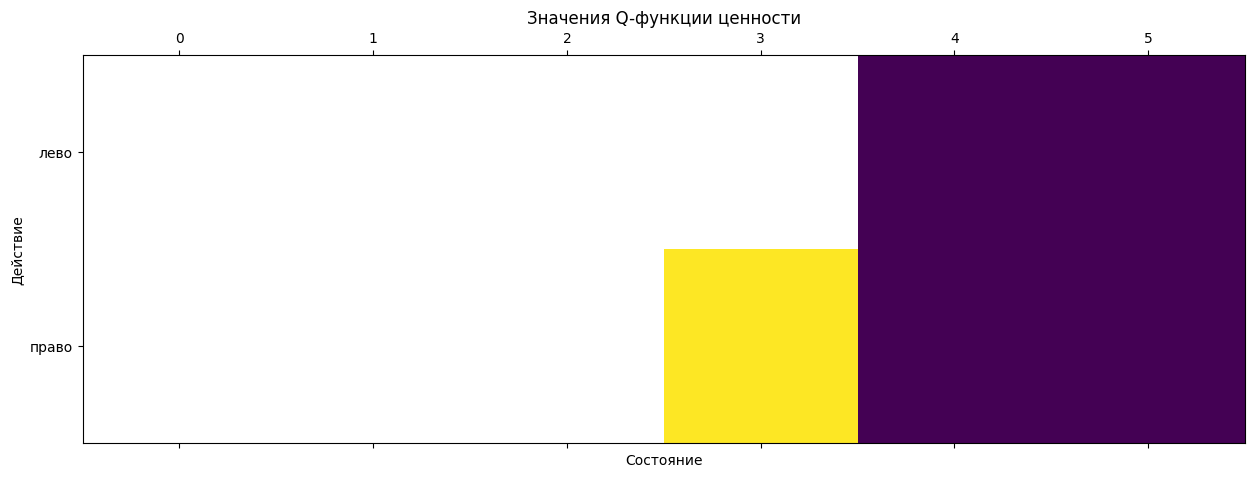

In [96]:
plot_policy(agent)

Видно, что агент использует неоптимальную стратегию и продолжает идти налево, не зная про вариант получше.

#### Posterior sampling RL

Настало время реализовать сэмплирование по Томпсону для MDP!

Алгоритм:

>**for** эпизода $k = 1,2,...$ **do**
>> сэмплировать $M_k \sim f(\bullet\ |\ H_k)$

>> Вычислить политику $\mu_k$ для $M_k$

>> **for** шагов $t = 1, 2,...$ **do**

>>> выбрать действие  $a_t$ из $\mu_k$

>>> получить $r_t$ и $s_{t+1}$
>>> обновить $H_k$

>> **end for**

>**end for**

Марковский процесс принятия решений $M_k$ представлен двумя матрицами: вероятности переходов и награды. Матрица переходов сэмплируется из распределения Дирихле, в то время как матрица наград сэмплируется из гамма-нормального распределения.

Распределения обновляются согласно правилу Байеса (см. https://en.wikipedia.org/wiki/Conjugate_prior для непрерывных распределений).

Дополнительные материалы &mdash; https://arxiv.org/abs/1306.0940.

In [102]:
def sample_normal_gamma(mu, lmbd, alpha, beta):
    """ https://en.wikipedia.org/wiki/Normal-gamma_distribution
    """
    tau = np.random.gamma(alpha, beta)
    mu = np.random.normal(mu , 1. / np.sqrt(lmbd * tau))
    return mu, tau


class PsrlAgent:
    def __init__(self, n_states, n_actions, horizon=10):
        self._n_states = n_states
        self._n_actions = n_actions
        self._horizon = horizon

        # параметры для сэмплирования матрицы переходов --- распределение Дирихле
        self._transition_counts = np.zeros((n_states, n_states, n_actions)) + 1.

        # параметры для сэмплирования наград --- гамма-нормальное распределение
        self._mu_matrix = np.zeros((n_states, n_actions)) + 1.
        self._state_action_counts = np.zeros((n_states, n_actions)) + 1.  # lambda

        self._alpha_matrix = np.zeros((n_states, n_actions)) + 1.
        self._beta_matrix = np.zeros((n_states, n_actions)) + 1.

        # Для хранения суммы наград и суммы квадратов наград (для обновления beta_matrix)
        self._reward_sum = np.zeros((n_states, n_actions))
        self._reward_squared_sum = np.zeros((n_states, n_actions))



    def _value_iteration(self, transitions, rewards):
        state_values = np.zeros(self._n_states)

        for _ in range(self._horizon):
            q_values = np.zeros((self._n_states, self._n_actions))
            for s in range(self._n_states):
                for a in range(self._n_actions):

                    expected_future_value = np.sum(transitions[s, :, a] * state_values)
                    q_values[s, a] = rewards[s, a] + expected_future_value

            state_values = np.max(q_values, axis=1)

        return state_values

    def start_episode(self):
        # сэмпл нового Марковского процесса принятия решений
        self._sampled_transitions = np.apply_along_axis(np.random.dirichlet, 1, self._transition_counts)

        sampled_reward_mus, sampled_reward_stds = sample_normal_gamma(
            self._mu_matrix,
            self._state_action_counts,
            self._alpha_matrix,
            self._beta_matrix
        )


        self._sampled_rewards = sampled_reward_mus
        self._current_value_function = self._value_iteration(self._sampled_transitions, self._sampled_rewards)

    def get_action(self, state):
        return np.argmax(self._sampled_rewards[state] +
                         self._current_value_function.dot(self._sampled_transitions[state]))

    def update(self, state, action, reward, next_state):

        self._transition_counts[state, next_state, action] += 1
        self._mu_matrix[state, action] = (self._state_action_counts[state, action] * self._mu_matrix[state, action] + reward) / (self._state_action_counts[state, action] + 1)


        self._alpha_matrix[state, action] += 0.5

        self._reward_sum[state, action] += reward
        self._reward_squared_sum[state, action] += reward**2
        self._state_action_counts[state, action] += 1

        lambda_prev = self._state_action_counts[state, action]
        mu_prev = self._mu_matrix[state, action]
        alpha_prev = self._alpha_matrix[state, action]
        beta_prev = self._beta_matrix[state, action]

        self._state_action_counts[state, action] = lambda_prev + 1
        self._mu_matrix[state, action] = (lambda_prev * mu_prev + reward) / self._state_action_counts[state, action]
        self._alpha_matrix[state, action] = alpha_prev + 0.5
        self._beta_matrix[state, action] = beta_prev + 0.5 * (reward**2 + lambda_prev * mu_prev**2 - self._state_action_counts[state, action] * self._mu_matrix[state, action]**2)

    def get_q_matrix(self):
        # Возвращаем Q-функцию, полученную из сэмплированного MDP во время start_episode
        q_func = np.zeros((self._n_states, self._n_actions))
        for s in range(self._n_states):
            for a in range(self._n_actions):
                q_func[s,a] = self._sampled_rewards[s,a] + \
                              np.sum(self._sampled_transitions[s,:,a] * self._current_value_function)
        return q_func
        # правила обновления --- https://en.wikipedia.org/wiki/Conjugate_prior

    def get_q_matrix(self):
        return self._sampled_rewards + self._current_value_function.dot(self._sampled_transitions)


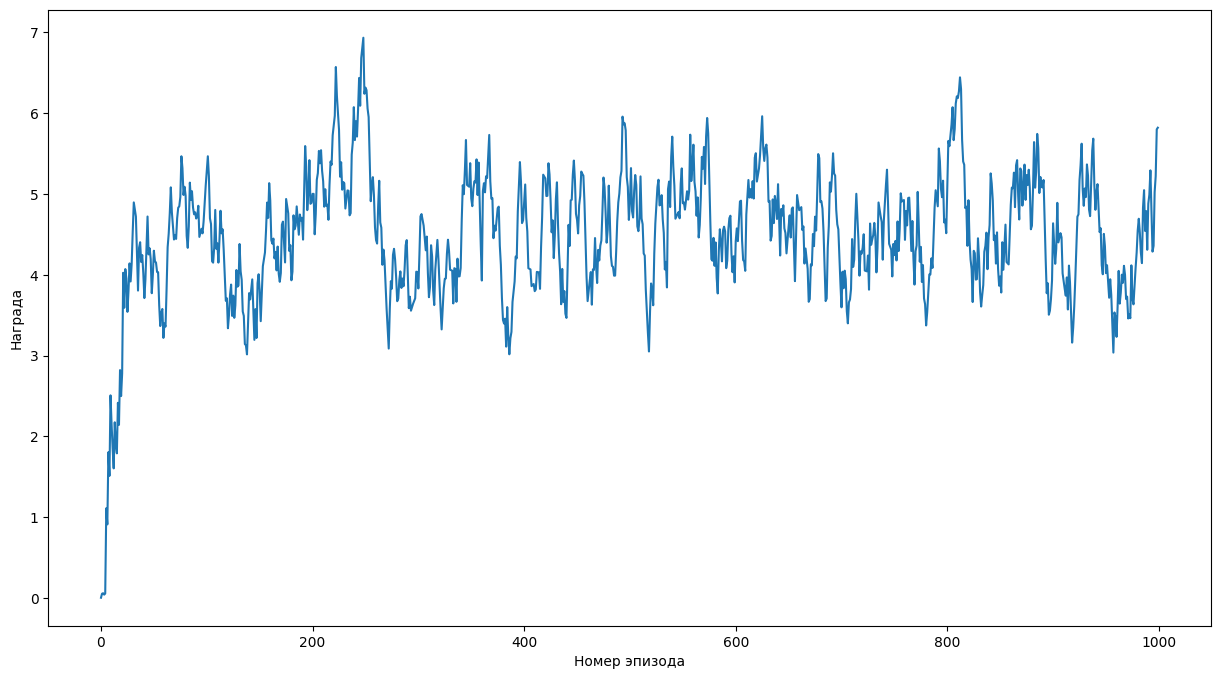

CPU times: user 1.06 s, sys: 9.56 ms, total: 1.07 s
Wall time: 1.07 s


In [103]:
%%time
np.random.seed(SEED)


horizon = 20
env = RiverSwimEnv(max_steps=horizon)
agent = PsrlAgent(env.n_states, env.n_actions, horizon=horizon)
rews = train_mdp_agent(agent, env, 1000)

plt.figure(figsize=(15, 8))
plt.plot(pd.DataFrame.ewm(pd.DataFrame(np.array(rews)), alpha=0.1).mean())

plt.xlabel("Номер эпизода")
plt.ylabel("Награда")
plt.show()

/var/folders/_6/2rn_7pxd0753xpzw6bky5hnr0000gn/T/ipykernel_30070/1341710020.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(["", "лево", "право"])


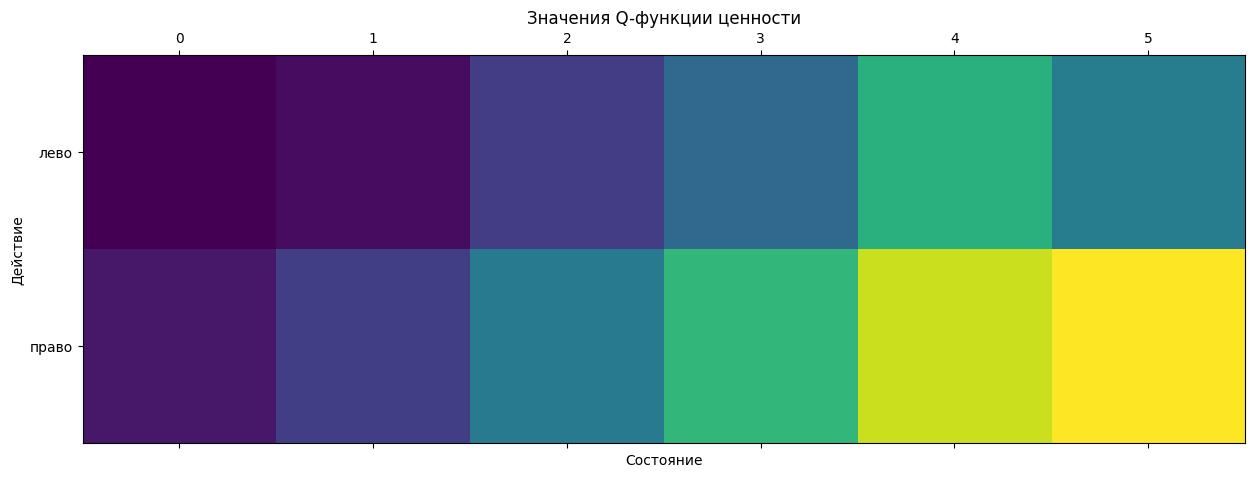

In [104]:
plot_policy(agent)